# A notebook for cumulative sc graphs

In [1]:
import napari
from cellpose import models
from macrohet import dataio, tile
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)
from napari_animation import Animation
from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

from macrohet import tools

### Load all metadata

Both the image metadata and the assay layout metadata

In [2]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet/'
metadata_fn = os.path.join(base_dir, 'Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = os.path.join(base_dir, 'Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [4]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):
    ### load tracks
    with btrack.dataio.HDF5FileHandler(
            f"/mnt/DATA/macrohet/labels/full_localisation/downscaled/({row}, {column})_downsc_objs_masks_tracks.h5", 
            'r', 
            obj_type = 'obj_type_1', 
            ) as hdf: 
            tracks = hdf.tracks
#             objs = hdf.objects
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/04/20 01:37:41 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 4)_downsc_objs_masks_tracks.h5...
[INFO][2023/04/20 01:37:41 PM] Loading tracks/obj_type_1
[INFO][2023/04/20 01:37:41 PM] Loading objects/obj_type_1 (25554, 5) (25554 filtered: None)
[INFO][2023/04/20 01:37:42 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 4)_downsc_objs_masks_tracks.h5
[INFO][2023/04/20 01:37:42 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5...
[INFO][2023/04/20 01:37:42 PM] Loading tracks/obj_type_1
[INFO][2023/04/20 01:37:42 PM] Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
[INFO][2023/04/20 01:37:42 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5
[INFO][2023/04/20 01:37:42 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 6)_downsc_objs_masks_tracks.h5..

[INFO][2023/04/20 01:37:55 PM] Loading tracks/obj_type_1
[INFO][2023/04/20 01:37:56 PM] Loading objects/obj_type_1 (28008, 5) (28008 filtered: None)
[INFO][2023/04/20 01:37:56 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(6, 5)_downsc_objs_masks_tracks.h5
[INFO][2023/04/20 01:37:56 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(6, 6)_downsc_objs_masks_tracks.h5...
[INFO][2023/04/20 01:37:56 PM] Loading tracks/obj_type_1
[INFO][2023/04/20 01:37:56 PM] Loading objects/obj_type_1 (25123, 5) (25123 filtered: None)
[INFO][2023/04/20 01:37:56 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(6, 6)_downsc_objs_masks_tracks.h5
[INFO][2023/04/20 01:37:56 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(6, 7)_downsc_objs_masks_tracks.h5...
[INFO][2023/04/20 01:37:56 PM] Loading tracks/obj_type_1
[INFO][2023/04/20 01:37:56 PM] Loading objects/obj_type_1 (27885, 5) (27885 filtere

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [5]:
### list of track info dfs
dfs = list()
### empty dictionary for filtered tracks
filtered_tracks = dict()
### iterate over all tracks
for key in tracks_dict.keys():
    ### extract tracks only with max length
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) >34] #== 75]
    ### iterate over full length tracks
    for track in filtered_tracks[key]:
        ### get info for assay layout
        info = assay_layout.loc[key]
        ### compile single track dictionary of info
        d = {'Time (hours)':track['t'], 
             'x':track['x'],
             'y':track['y'],
             'Area':track['area'], 
             'Intracellular Mtb content':track['mean_intensity-1'],
             'dMtb/dt':track['mean_intensity-1'],
             'Macroph. GFP expression':track['mean_intensity-0'],
             'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
             'MSD': [tools.euc_dist(track['x'][i-1], 
                                    track['y'][i-1], 
                                    track['x'][i], 
                                    track['y'][i]) 
                      if i != 0 else 0
                      for i in range(0, len(track))],
             'Strain':[info['Strain'] for i in range(len(track['t']))], 
             'Compound':[info['Compound'] for i in range(len(track['t']))], 
             'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
             'Cell ID':[track.ID for i in range(len(track['t']))],
             'Acquisition ID':[key for i in range(len(track['t']))]}
        ### append df to list of dfs
        dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
df = pd.concat(dfs, ignore_index=True)
df

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID
0,0,1050.816895,19.046474,2539.0,0.005487,0.017871,0.912557,0.000000,RD1,CTRL,EC0,344,"(3, 4)"
1,1,1069.464722,16.152050,2098.0,0.005470,0.018236,0.870907,18.871119,RD1,CTRL,EC0,344,"(3, 4)"
2,2,1074.024780,16.110592,2143.0,0.005451,0.017062,0.884658,4.560247,RD1,CTRL,EC0,344,"(3, 4)"
3,3,1070.232544,12.069767,1591.0,0.005442,0.018409,0.905547,5.541599,RD1,CTRL,EC0,344,"(3, 4)"
4,4,1073.632935,13.351424,1861.0,0.005454,0.017631,0.922291,3.633910,RD1,CTRL,EC0,344,"(3, 4)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
348145,70,263.636963,1030.464722,2548.0,0.006251,0.035022,0.781741,6.429717,WT,BDQ,EC99,2035,"(6, 9)"
348146,71,270.823517,1039.534180,2516.0,0.006238,0.033061,0.789968,11.571587,WT,BDQ,EC99,2035,"(6, 9)"
348147,72,286.121796,1044.373535,2915.0,0.006036,0.029789,0.796342,16.045457,WT,BDQ,EC99,2035,"(6, 9)"
348148,73,290.993134,1048.557495,3200.0,0.005887,0.029728,0.643475,6.421484,WT,BDQ,EC99,2035,"(6, 9)"


# Create a separate df for "survivor" tracks

i.e. all tracks that last the length of the time lapse

In [6]:
### list of track info dfs
dfs = list()
### empty dictionary for filtered tracks
filtered_tracks = dict()
### iterate over all tracks
for key in tracks_dict.keys():
    ### extract tracks only with max length
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) == 75]
    ### iterate over full length tracks
    for track in filtered_tracks[key]:
        ### get info for assay layout
        info = assay_layout.loc[key]
        ### compile single track dictionary of info
        d = {'Time (hours)':track['t'], 
             'x':track['x'],
             'y':track['y'],
             'Area':track['area'], 
             'Intracellular Mtb content':track['mean_intensity-1'],
             'Macroph. GFP expression':track['mean_intensity-0'],
             'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
             'MSD': [tools.euc_dist(track['x'][i-1], 
                                    track['y'][i-1], 
                                    track['x'][i], 
                                    track['y'][i]) 
                      if i != 0 else 0
                      for i in range(0, len(track))],
             'Strain':[info['Strain'] for i in range(len(track['t']))], 
             'Compound':[info['Compound'] for i in range(len(track['t']))], 
             'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
             'Cell ID':[track.ID for i in range(len(track['t']))],
             'Acquisition ID':[key for i in range(len(track['t']))]}
        ### append df to list of dfs
        dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
full_len_df = pd.concat(dfs, ignore_index=True)
full_len_df

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID
0,0,1169.847412,13.893421,760.0,0.005136,0.014705,0.809516,0.000000,RD1,CTRL,EC0,343,"(3, 4)"
1,1,1172.826538,14.674929,1049.0,0.005121,0.013235,0.843927,3.079926,RD1,CTRL,EC0,343,"(3, 4)"
2,2,1174.588867,14.375803,934.0,0.005116,0.013899,0.719524,1.787535,RD1,CTRL,EC0,343,"(3, 4)"
3,3,1175.250610,12.160207,774.0,0.005094,0.013428,0.739700,2.312308,RD1,CTRL,EC0,343,"(3, 4)"
4,4,1180.553955,9.897770,538.0,0.005071,0.012774,0.761300,5.765768,RD1,CTRL,EC0,343,"(3, 4)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81520,70,559.663025,1177.240234,3018.0,0.005635,0.024949,0.698306,3.245095,WT,BDQ,EC99,155,"(6, 9)"
81521,71,556.457581,1178.115601,2863.0,0.005609,0.024090,0.716728,3.322821,WT,BDQ,EC99,155,"(6, 9)"
81522,72,559.905823,1178.514648,3047.0,0.005600,0.022092,0.789115,3.471255,WT,BDQ,EC99,155,"(6, 9)"
81523,73,565.014221,1180.512939,2737.0,0.005606,0.021206,0.822009,5.485335,WT,BDQ,EC99,155,"(6, 9)"


### Add category to discern initial amount of Mtb growth

Categorical

In [15]:
initial_mtb = df.loc[df['Time (hours)'] == 0, 'Intracellular Mtb content']
initial_mtb_quartiles = pd.cut(initial_mtb, bins = [initial_mtb.quantile(.0), 
                                                    initial_mtb.quantile(.25), 
                                                    initial_mtb.quantile(0.5), 
                                                    initial_mtb.quantile(.75),
                                                    initial_mtb.quantile(1)], 
                                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
df['Initial Mtb load (quartile)'] = initial_mtb_quartiles
df.fillna(method='ffill', inplace=True)

### Mtb growth segregated by initial Mtb load -- for all tracks longer than half the timelapse

Text(0.5, 1.0, 'Cumulative single-macrophage intracellular Mtb growth, segregated by initial Mtb load')

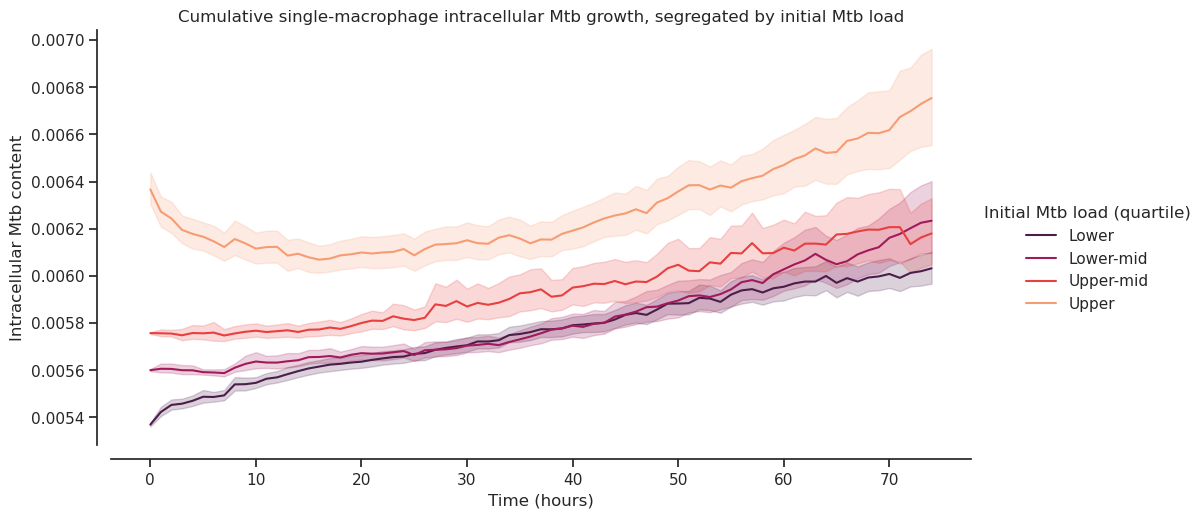

In [16]:
# sns.set_palette('RdYlGn')/
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Initial Mtb load (quartile)', kind = 'line',
            aspect = 2, alpha = 1, 
            palette=sns.color_palette('rocket', n_colors=4, ), 
            
           )
sns.despine(offset=10, trim=False)
plt.title('Cumulative single-macrophage intracellular Mtb growth, segregated by initial Mtb load')

### Same graph but for survivor tracks

In [14]:
initial_mtb = full_len_df.loc[full_len_df['Time (hours)'] == 0, 'Intracellular Mtb content']
initial_mtb_quartiles = pd.cut(initial_mtb, bins = [initial_mtb.quantile(.0), 
                                                    initial_mtb.quantile(.25), 
                                                    initial_mtb.quantile(0.5), 
                                                    initial_mtb.quantile(.75),
                                                    initial_mtb.quantile(1)], 
                                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
full_len_df['Initial Mtb load (quartile)'] = initial_mtb_quartiles
full_len_df.fillna(method='ffill', inplace=True)

Text(0.5, 1.0, 'Cumulative single-macrophage (survivors only) intracellular Mtb growth, segregated by initial Mtb load')

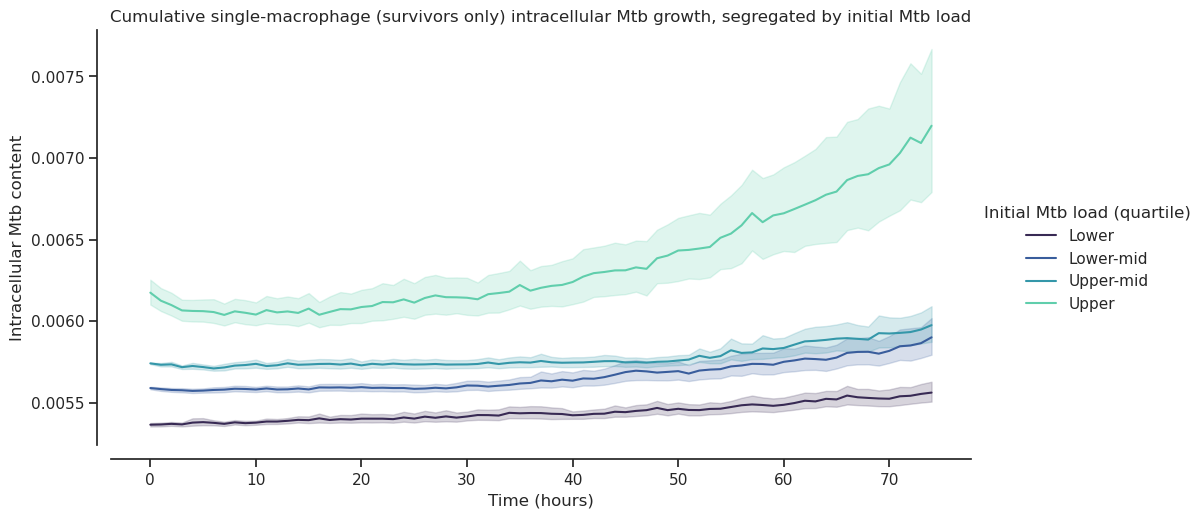

In [33]:
# sns.set_palette('RdYlGn')/
sns.relplot(data = full_len_df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Initial Mtb load (quartile)', kind = 'line',
            aspect = 2, alpha = 1, 
            palette=sns.color_palette('mako', n_colors=4, )            
           )
sns.despine(offset=10, trim=False)
plt.title('Cumulative single-macrophage (survivors only) intracellular Mtb growth, segregated by initial Mtb load')

# Now segregating on final Mtb load

In [30]:
final_mtb = df.loc[df['Time (hours)'] == 74, 'Intracellular Mtb content']
final_mtb_quartiles = pd.cut(final_mtb, bins = [final_mtb.quantile(.0), 
                                                    final_mtb.quantile(.25), 
                                                    final_mtb.quantile(0.5), 
                                                    final_mtb.quantile(.75),
                                                    final_mtb.quantile(1)], 
                                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
df['Final Mtb load (quartile)'] = final_mtb_quartiles
df.fillna(method='bfill', inplace=True)

Text(0.5, 1.0, 'Cumulative single-macrophage intracellular Mtb growth, segregated by final Mtb load')

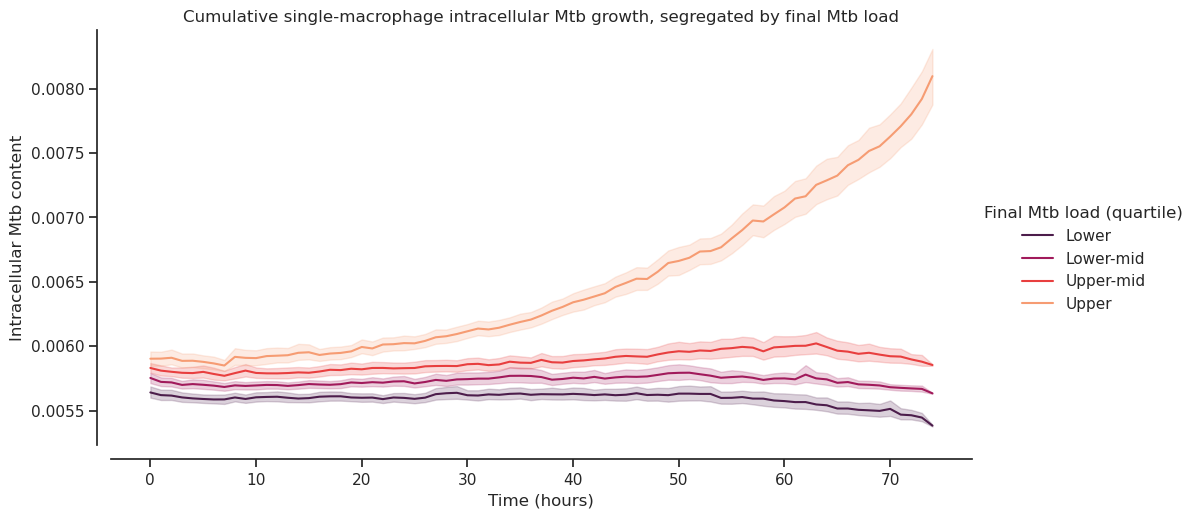

In [34]:
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Final Mtb load (quartile)', kind = 'line',
            aspect = 2,
            palette=sns.color_palette('rocket', n_colors=4, ), 
           )
sns.despine(offset=10, trim=False)
plt.title('Cumulative single-macrophage intracellular Mtb growth, segregated by final Mtb load')

### Now for survivor cells

In [35]:
final_mtb = full_len_df.loc[full_len_df['Time (hours)'] == 74, 'Intracellular Mtb content']
final_mtb_quartiles = pd.cut(final_mtb, bins = [final_mtb.quantile(.0), 
                                                    final_mtb.quantile(.25), 
                                                    final_mtb.quantile(0.5), 
                                                    final_mtb.quantile(.75),
                                                    final_mtb.quantile(1)], 
                                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
full_len_df['Final Mtb load (quartile)'] = final_mtb_quartiles
full_len_df.fillna(method='bfill', inplace=True)

Text(0.5, 1.0, 'Cumulative single-macrophage (survivors only) intracellular Mtb growth, segregated by final Mtb load')

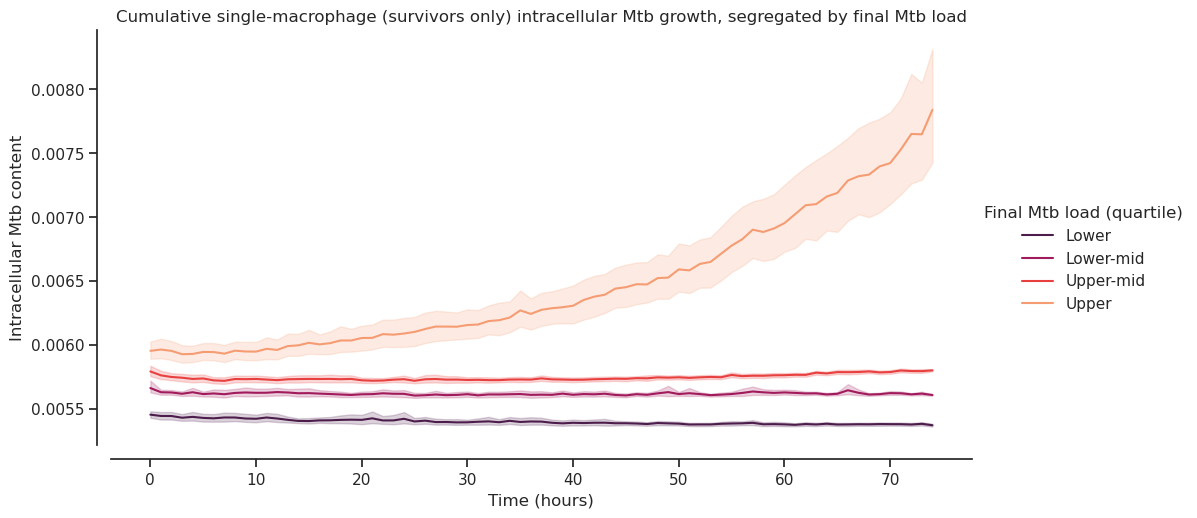

In [36]:
sns.relplot(data = full_len_df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Final Mtb load (quartile)', kind = 'line',
            aspect = 2,
            palette=sns.color_palette('rocket', n_colors=4, ), 
           )
sns.despine(offset=10, trim=False)
plt.title('Cumulative single-macrophage (survivors only) intracellular Mtb growth, segregated by final Mtb load')

# Plotting the effect of antibiotics

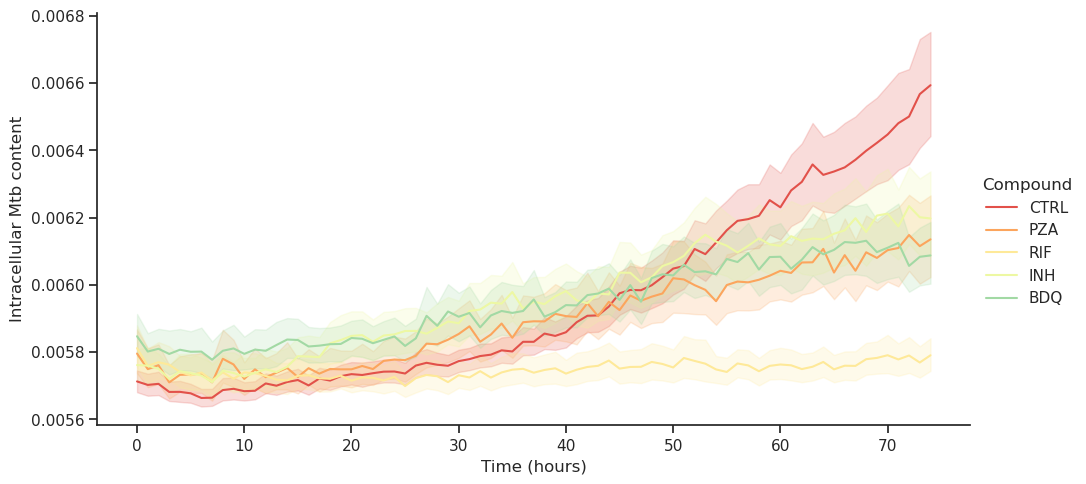

In [7]:
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Compound', kind = 'line',
            aspect = 2,
           )

In [10]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [13]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

# Effect of ATB on WT

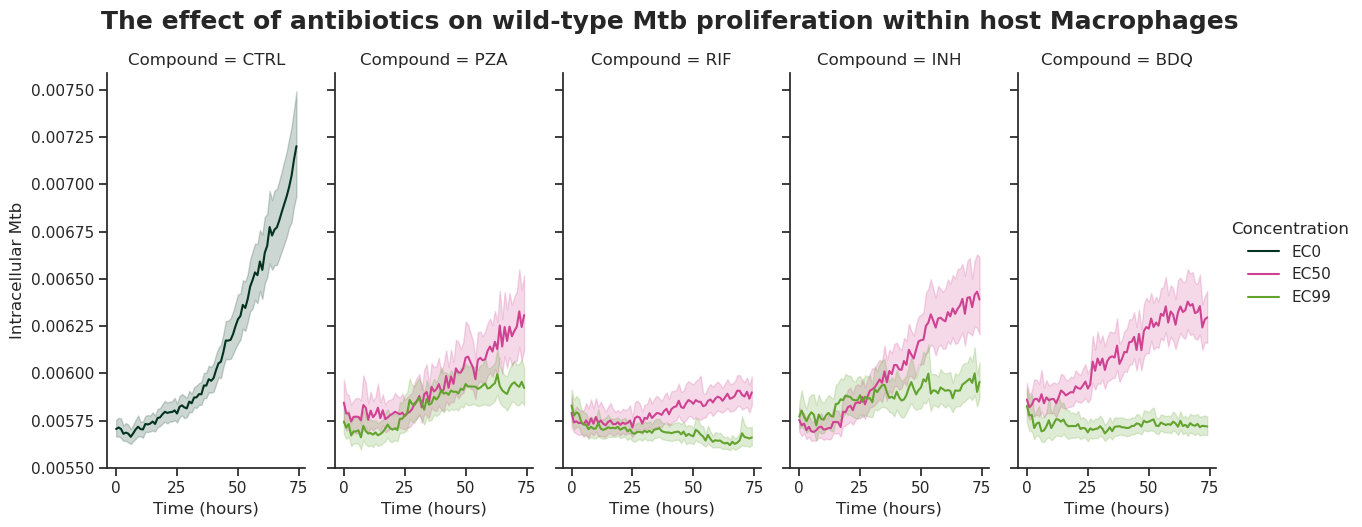

In [64]:
g = sns.relplot(data = df[df['Strain'] != 'RD1'], 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Concentration', 
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=colors
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/ATB_effect_WT_Mtb.png', bbox_inches = 'tight', dpi = 314)

# Isolating just the control and ideal ATB case

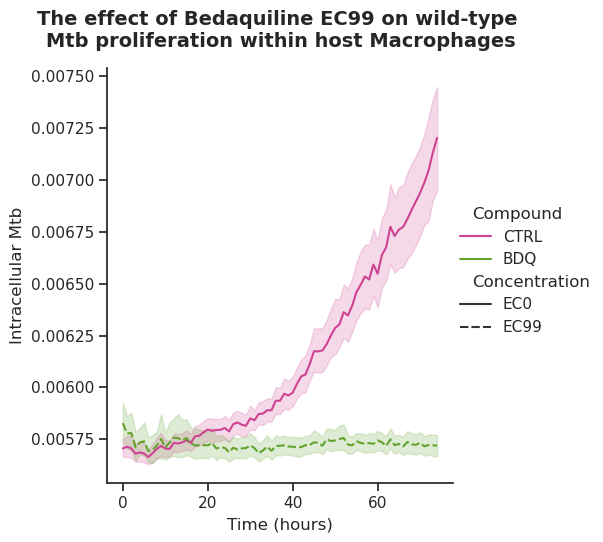

In [66]:
g = sns.relplot(data = df[(df['Strain'] != 'RD1') &
                          (df['Compound'] == 'CTRL') |
                          (df['Compound'] == 'BDQ') &
                          (df['Concentration'] == 'EC99')], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Concentration',
            hue= 'Compound',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline EC99 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/BDQ_CTRL_effect_WT_Mtb.png', bbox_inches = 'tight', dpi = 314)

## Focusing on BDQ

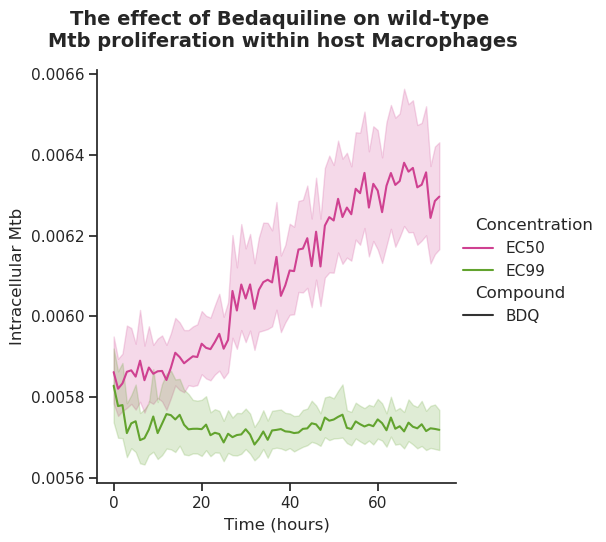

In [91]:
g = sns.relplot(data = df[(df['Compound'] == 'BDQ')
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Compound',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/BDQ_effect_WT_Mtb.png', bbox_inches = 'tight', dpi = 314)

### Checking difference (if any) between repeat experiments

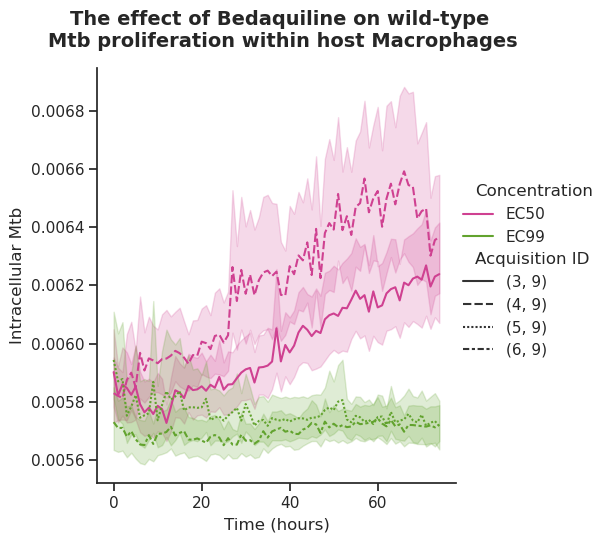

In [92]:
g = sns.relplot(data = df[(df['Compound'] == 'BDQ')
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Acquisition ID',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/BDQ_effect_WT_Mtb_separated_by_expt.png', bbox_inches = 'tight', dpi = 314)

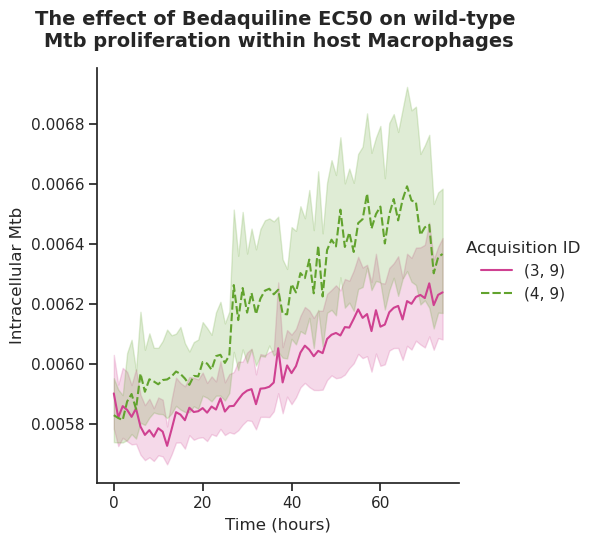

In [97]:
g = sns.relplot(data = df[(df['Compound'] == 'BDQ') &
               (df['Concentration'] == 'EC50')
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Acquisition ID',
            hue= 'Acquisition ID',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/BDQ_EC50_effect_WT_Mtb_separated_by_expt.png', bbox_inches = 'tight', dpi = 314)

In [185]:
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

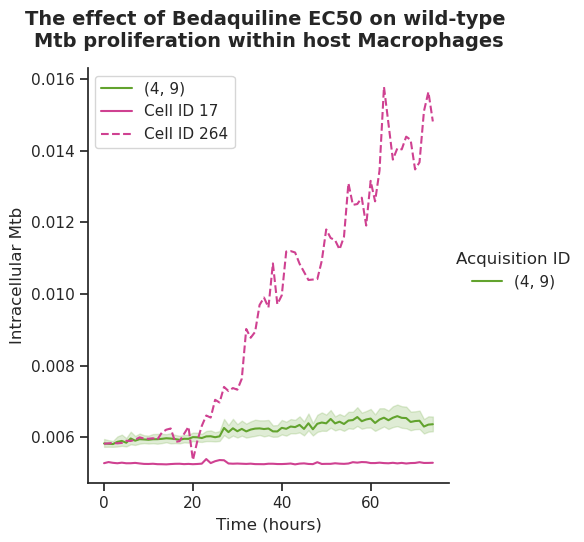

In [190]:
g = sns.relplot(data = df[(df['Acquisition ID'] == (4, 9))], 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Acquisition ID',
            hue= 'Acquisition ID',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[-1]],                 
           )
sns.lineplot(x = expt_49[expt_49['Cell ID'] == 17]['Time (hours)'], 
             y = expt_49[expt_49['Cell ID'] == 17]['Intracellular Mtb content'], 
            label = 'Cell ID 17', linestyle='-', color = colors[1])
sns.lineplot(x = expt_49[expt_49['Cell ID'] == 264]['Time (hours)'], 
             y = expt_49[expt_49['Cell ID'] == 264]['Intracellular Mtb content'],
             label = 'Cell ID 264', linestyle='--', color = colors[1])
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/BDQ_EC50_effect_WT_Mtb_with_sc_extremes.png', bbox_inches = 'tight', dpi = 314)

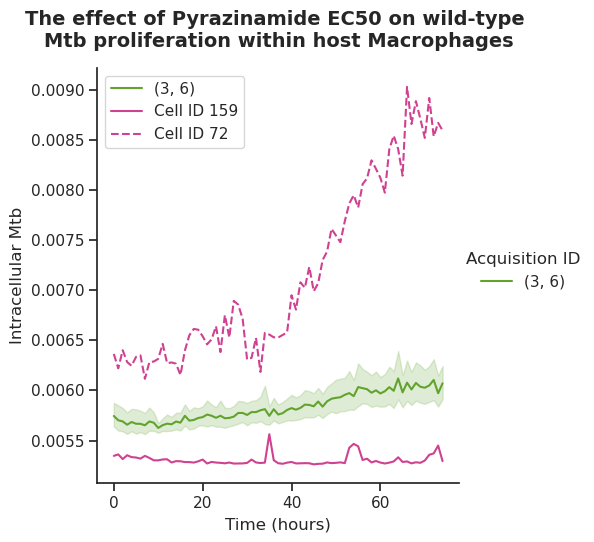

In [194]:
expt = df[(df['Acquisition ID'] == (3, 6))]

g = sns.relplot(data = expt, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Acquisition ID',
            hue= 'Acquisition ID',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[-1]],                 
           )

sns.lineplot(x = expt[expt['Cell ID'] == 159]['Time (hours)'], 
             y = expt[expt['Cell ID'] == 159]['Intracellular Mtb content'], 
            label = 'Cell ID 159', linestyle='-', color = colors[1])
sns.lineplot(x = expt[expt['Cell ID'] == 72]['Time (hours)'], 
             y = expt[expt['Cell ID'] == 72]['Intracellular Mtb content'],
             label = 'Cell ID 72', linestyle='--', color = colors[1])
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Pyrazinamide EC50 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/PZA_EC50_effect_WT_Mtb_with_sc_extremes.png', bbox_inches = 'tight', dpi = 314)

In [172]:
expt_49[expt_49['Cell ID'] == 17]

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Mean Mtb content,Mtb content range
175359,0,787.419189,841.815674,2376.0,0.005280,0.018034,0.876459,0.000000,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175360,1,792.964844,841.721985,2248.0,0.005311,0.023384,0.883034,5.546446,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175361,2,794.169678,845.634888,2487.0,0.005290,0.022281,0.858829,4.094195,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175362,3,794.383545,844.478271,2902.0,0.005278,0.020764,0.867945,1.176223,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175363,4,793.184143,845.630737,2911.0,0.005294,0.021835,0.858054,1.663353,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175429,70,802.580017,847.569946,2967.0,0.005287,0.027800,0.768146,0.856586,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175430,71,798.543762,851.178406,2685.0,0.005307,0.030774,0.778602,5.414087,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175431,72,801.885193,850.783386,3379.0,0.005286,0.026049,0.710469,3.364699,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175432,73,800.708435,854.149414,3286.0,0.005287,0.023522,0.581367,3.565796,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148


# What proportion of cells are positive?

### Subsection:

how do i determine what is an Mtb+ cell?

In [203]:
expt_35 =  df[(df['Acquisition ID'] == (3, 5))]
expt_35

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID
13584,0,214.715118,649.776428,4602.0,0.005709,0.019985,0.630087,0.000000,WT,CTRL,EC0,311,"(3, 5)"
13585,1,214.955872,648.901794,4329.0,0.005699,0.023402,0.777214,0.907164,WT,CTRL,EC0,311,"(3, 5)"
13586,2,223.674240,650.713928,3877.0,0.005765,0.031596,0.599604,8.904705,WT,CTRL,EC0,311,"(3, 5)"
13587,3,221.003372,652.696777,4449.0,0.005688,0.020448,0.548114,3.326443,WT,CTRL,EC0,311,"(3, 5)"
13588,4,219.889526,644.160156,4571.0,0.005681,0.017730,0.519863,8.608981,WT,CTRL,EC0,311,"(3, 5)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28554,70,427.750946,949.322754,1072.0,0.005310,0.024622,0.776626,2.432187,WT,CTRL,EC0,2102,"(3, 5)"
28555,71,428.007202,949.946960,1112.0,0.005436,0.027250,0.811426,0.674760,WT,CTRL,EC0,2102,"(3, 5)"
28556,72,428.304993,950.134827,NaN,NaN,NaN,NaN,0.352098,WT,CTRL,EC0,2102,"(3, 5)"
28557,73,426.652954,953.069397,778.0,0.005344,0.030359,0.750405,3.367630,WT,CTRL,EC0,2102,"(3, 5)"


In [204]:
len(set(expt_35['Cell ID'].values))

265

Text(0.5, 1.0, 'Distribution of intracellular RFP values')

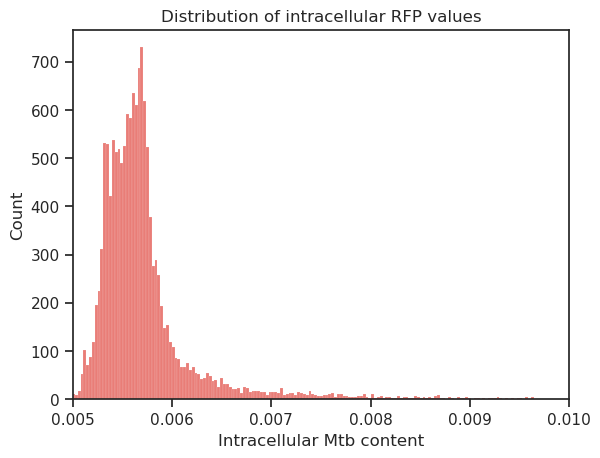

In [208]:
sns.histplot(expt_35['Intracellular Mtb content'])
plt.xlim(0.005, 0.010)
plt.title('Distribution of intracellular RFP values')

### What does the initial distribution look like?

Text(0.5, 1.0, 'Distribution of intracellular RFP values at t=0')

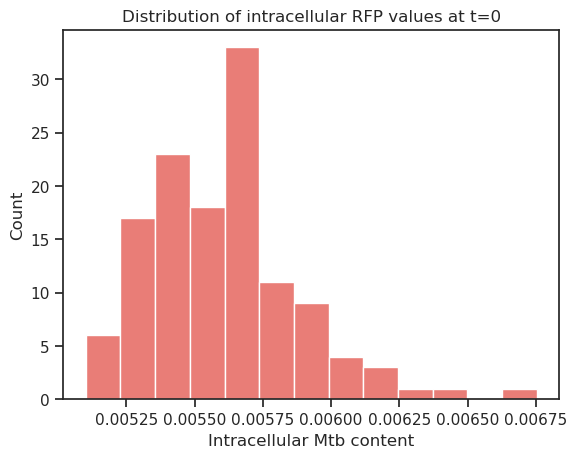

In [241]:
sns.histplot(expt_35[expt_35['Time (hours)'] == 0]['Intracellular Mtb content'])
# plt.xlim(0.005, 0.010)
plt.title('Distribution of intracellular RFP values at t=0')

### SC track

In [242]:
expt_35[expt_35['Intracellular Mtb content'] > 0.0055]

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID
13584,0,214.715118,649.776428,4602.0,0.005709,0.019985,0.630087,0.000000,WT,CTRL,EC0,311,"(3, 5)"
13585,1,214.955872,648.901794,4329.0,0.005699,0.023402,0.777214,0.907164,WT,CTRL,EC0,311,"(3, 5)"
13586,2,223.674240,650.713928,3877.0,0.005765,0.031596,0.599604,8.904705,WT,CTRL,EC0,311,"(3, 5)"
13587,3,221.003372,652.696777,4449.0,0.005688,0.020448,0.548114,3.326443,WT,CTRL,EC0,311,"(3, 5)"
13588,4,219.889526,644.160156,4571.0,0.005681,0.017730,0.519863,8.608981,WT,CTRL,EC0,311,"(3, 5)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28540,56,395.083557,949.088623,2178.0,0.005793,0.051637,0.671561,2.736360,WT,CTRL,EC0,2102,"(3, 5)"
28541,57,392.455231,951.213318,2166.0,0.005736,0.046103,0.671218,3.379708,WT,CTRL,EC0,2102,"(3, 5)"
28542,58,396.493347,949.908752,2477.0,0.005618,0.042646,0.640626,4.243616,WT,CTRL,EC0,2102,"(3, 5)"
28543,59,395.170349,951.098389,2266.0,0.005682,0.041830,0.732371,1.779202,WT,CTRL,EC0,2102,"(3, 5)"


In [229]:
sc_311 = expt_35[expt_35['Cell ID'] == 311]

In [235]:
sc_311

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID
13584,0,214.715118,649.776428,4602.0,0.005709,0.019985,0.630087,0.000000,WT,CTRL,EC0,311,"(3, 5)"
13585,1,214.955872,648.901794,4329.0,0.005699,0.023402,0.777214,0.907164,WT,CTRL,EC0,311,"(3, 5)"
13586,2,223.674240,650.713928,3877.0,0.005765,0.031596,0.599604,8.904705,WT,CTRL,EC0,311,"(3, 5)"
13587,3,221.003372,652.696777,4449.0,0.005688,0.020448,0.548114,3.326443,WT,CTRL,EC0,311,"(3, 5)"
13588,4,219.889526,644.160156,4571.0,0.005681,0.017730,0.519863,8.608981,WT,CTRL,EC0,311,"(3, 5)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13654,70,196.244843,626.867676,6780.0,0.005760,0.027699,0.509469,3.140078,WT,CTRL,EC0,311,"(3, 5)"
13655,71,196.437561,625.516357,5645.0,0.005787,0.032635,0.481300,1.364991,WT,CTRL,EC0,311,"(3, 5)"
13656,72,190.767700,626.279602,3827.0,0.005774,0.030668,0.694586,5.721002,WT,CTRL,EC0,311,"(3, 5)"
13657,73,190.557938,619.748474,1821.0,0.005785,0.029402,0.574261,6.534496,WT,CTRL,EC0,311,"(3, 5)"


In [233]:
mtb = sc_311['Intracellular Mtb content']

<AxesSubplot:ylabel='Intracellular Mtb content'>

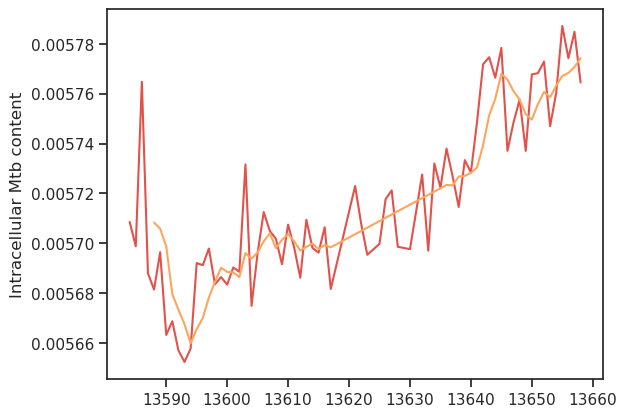

In [234]:
sns.lineplot(data = sc_311['Intracellular Mtb content'])
sns.lineplot(data = sc_311['Intracellular Mtb content'].rolling(window=5).mean())

In [225]:
track

,ID,t,x,y,z,parent,root,state,generation,dummy,orientation,area,mean_intensity-1,mean_intensity-0,minor_axis_length,major_axis_length
0,155,0,555.648987,1179.639893,0.0,155,155,5,0,False,0.811600,1094.0,0.005468,0.013893,27.485764,57.717491
1,155,1,555.648987,1179.639893,0.0,155,155,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
2,155,2,554.156250,1165.431519,0.0,155,155,5,0,False,0.648059,2688.0,0.005628,0.018413,38.810028,102.631187
3,155,3,550.792236,1156.691528,0.0,155,155,5,0,False,0.530133,4082.0,0.005608,0.019690,52.197090,101.140877
4,155,4,548.738403,1153.119019,0.0,155,155,5,0,False,0.472595,4301.0,0.005641,0.022936,53.929596,103.479881
5,155,5,548.794983,1148.502563,0.0,155,155,5,0,False,0.371089,4638.0,0.005620,0.021255,56.267254,106.584595
6,155,6,551.285889,1146.918457,0.0,155,155,5,0,False,0.254512,4712.0,0.005635,0.021566,55.822388,110.013023
7,155,7,551.167114,1154.885742,0.0,155,155,5,0,False,0.516713,3650.0,0.005583,0.022895,50.323452,96.223579
8,155,8,557.882751,1142.200684,0.0,155,155,5,0,False,0.111489,5221.0,0.005672,0.023741,64.365799,108.984268
9,155,9,566.869202,1143.670044,0.0,155,155,5,0,False,-0.317293,4724.0,0.005666,0.022816,62.962196,102.315086


In [227]:
pd.DataFrame(d)

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID
0,0,555.648987,1179.639893,1094.0,0.005468,0.013893,0.879330,0.000000,WT,BDQ,EC99,155,"(6, 9)"
1,1,555.648987,1179.639893,NaN,NaN,NaN,NaN,0.000000,WT,BDQ,EC99,155,"(6, 9)"
2,2,554.156250,1165.431519,2688.0,0.005628,0.018413,0.925744,14.286573,WT,BDQ,EC99,155,"(6, 9)"
3,3,550.792236,1156.691528,4082.0,0.005608,0.019690,0.856539,9.365042,WT,BDQ,EC99,155,"(6, 9)"
4,4,548.738403,1153.119019,4301.0,0.005641,0.022936,0.853459,4.120808,WT,BDQ,EC99,155,"(6, 9)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,559.663025,1177.240234,3018.0,0.005635,0.024949,0.698306,3.245095,WT,BDQ,EC99,155,"(6, 9)"
71,71,556.457581,1178.115601,2863.0,0.005609,0.024090,0.716728,3.322821,WT,BDQ,EC99,155,"(6, 9)"
72,72,559.905823,1178.514648,3047.0,0.005600,0.022092,0.789115,3.471255,WT,BDQ,EC99,155,"(6, 9)"
73,73,565.014221,1180.512939,2737.0,0.005606,0.021206,0.822009,5.485335,WT,BDQ,EC99,155,"(6, 9)"


(0.0055, 0.00575)

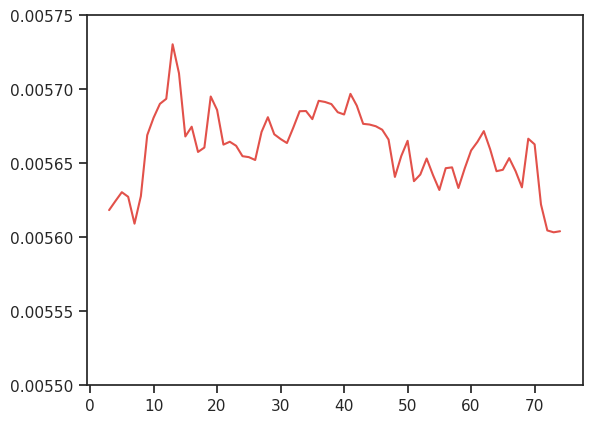

In [224]:
sns.lineplot(data = pd.Series(track['mean_intensity-1']).rolling(window=2).mean())
plt.ylim(0.0055, 0.00575)

Create a filter for cells that have high values of Mtb but low to no gradient

# Finding permissive cells
iterate over each cell ID, measure mean MTb content and delta Mtb?

In [104]:
expt_49 =  df[(df['Acquisition ID'] == (4, 9))]

In [123]:
expt_49['Mean Mtb content'] = 0
expt_49['Mtb content range'] = 0 

In [130]:
for cell_ID in set(expt_49['Cell ID'].values):
    mtb_content = expt_49[expt_49['Cell ID'] == cell_ID]['Intracellular Mtb content']
    mean_mtb_content = np.nanmean(mtb_content)
    mtb_range = mtb_content.max() - mtb_content.min()
    expt_49.loc[expt_49['Cell ID'] == cell_ID, 'Mean Mtb content'] = mean_mtb_content
    expt_49.loc[expt_49['Cell ID'] == cell_ID, 'Mtb content range'] = mtb_range

In [164]:
expt_49

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Mean Mtb content,Mtb content range
170130,0,807.646851,28.630100,1495.0,0.005247,0.021188,0.910061,0.000000,WT,BDQ,EC50,316,"(4, 9)",0.005456,0.002437
170131,1,801.725037,25.341858,2346.0,0.005269,0.022061,0.917806,6.773509,WT,BDQ,EC50,316,"(4, 9)",0.005456,0.002437
170132,2,813.769165,24.489822,2309.0,0.005349,0.022431,0.881027,12.074229,WT,BDQ,EC50,316,"(4, 9)",0.005456,0.002437
170133,3,817.738708,26.913771,1554.0,0.005258,0.023467,0.903340,4.651107,WT,BDQ,EC50,316,"(4, 9)",0.005456,0.002437
170134,4,822.214661,28.594780,2031.0,0.005278,0.020144,0.924089,4.781207,WT,BDQ,EC50,316,"(4, 9)",0.005456,0.002437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187891,70,698.321228,1145.136841,965.0,0.008777,0.074646,0.687517,2.071613,WT,BDQ,EC50,2219,"(4, 9)",0.008516,0.006350
187892,71,696.255859,1145.224121,1071.0,0.008059,0.074004,0.588318,2.067212,WT,BDQ,EC50,2219,"(4, 9)",0.008516,0.006350
187893,72,696.017639,1145.576294,963.0,0.007738,0.072355,0.658091,0.425176,WT,BDQ,EC50,2219,"(4, 9)",0.008516,0.006350
187894,73,695.198364,1147.363647,1089.0,0.007955,0.069467,0.672667,1.966175,WT,BDQ,EC50,2219,"(4, 9)",0.008516,0.006350


In [142]:
id_list = list()
for i in expt_49.sort_values('Mtb content range', ascending = False)['Cell ID'].values:
    if i not in id_list:
        id_list.append(i)
    else:
        continue
    if len(id_list) == 10:
        break

In [148]:
id_list

[1706, 477, 830, 1109, 1269, 25, 827, 1210, 1077, 1337]

In [149]:
id_list.remove(1706)

In [151]:
id_list

[477, 830, 1109, 1269, 25, 827, 1210, 1077, 1337]

<AxesSubplot:xlabel='Time (hours)', ylabel='Intracellular Mtb content'>

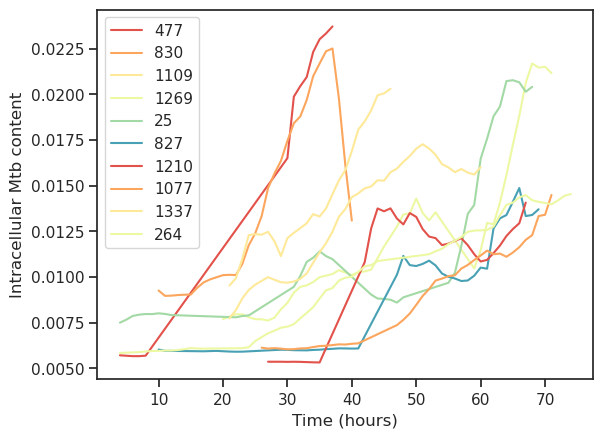

In [218]:
for cell_ID in id_list:
    sns.lineplot(y = expt_49[expt_49['Cell ID'] == cell_ID]['Intracellular Mtb content'].rolling(window=5).mean(), 
                 x = expt_49[expt_49['Cell ID'] == cell_ID]['Time (hours)'], label = cell_ID)
    
plt.legend()
sns.lineplot(y = expt_49[expt_49['Cell ID'] == 264]['Intracellular Mtb content'].rolling(window=5).mean(), 
                 x = expt_49[expt_49['Cell ID'] == 264]['Time (hours)'], label = 264)

## Iterating over each expt compound cond

In [159]:
antibiotic_dict = {
    "CTRL": "Control",
    "PZA": "Pyrazinamide",
    "RIF": "Rifampicin",
    "INH": "Isoniazid",
    "BDQ": "Bedaquiline"
}


In [157]:
for (row, col), info in assay_layout.iterrows():
    compound = info['Compound']
    print(compound)

CTRL
CTRL
PZA
RIF
INH
BDQ
CTRL
CTRL
PZA
RIF
INH
BDQ
CTRL
CTRL
PZA
RIF
INH
BDQ
CTRL
CTRL
PZA
RIF
INH
BDQ


In [162]:
for (row, col), info in assay_layout.iterrows():
    compound = info['Compound']
    if compound == 'CTRL':
        continue
    g = sns.relplot(data = df[(df['Compound'] == compound)
                         ], 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Compound',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )

    g.set_ylabels("Intracellular Mtb")

    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_effect_WT_Mtb.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    g = sns.relplot(data = df[(df['Compound'] == compound)
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Compound',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
   
    g.set_ylabels("Intracellular Mtb")
    
    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_effect_WT_Mtb.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    g = sns.relplot(data = df[(df['Compound'] == compound)
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Acquisition ID',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
    
    g.set_ylabels("Intracellular Mtb")
   
    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_effect_WT_Mtb_separated_by_expt.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    g = sns.relplot(data = df[(df['Compound'] == compound) &
                   (df['Concentration'] == 'EC50')
                             ], 

                x = 'Time (hours)', 
                y = 'Intracellular Mtb content', 
                style= 'Acquisition ID',
                hue= 'Acquisition ID',
    #             col= 'Compound',
                kind = 'line',
                aspect = 1,
                palette=[colors[1], colors[-1]]
               )

    g.set_ylabels("Intracellular Mtb")

    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} EC50 on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_EC50_effect_WT_Mtb_separated_by_expt.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

# Defining "infected" cut off for Mtb for one expt

In [165]:
expt_49

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Mean Mtb content,Mtb content range
170130,0,807.646851,28.630100,1495.0,0.005247,0.021188,0.910061,0.000000,WT,BDQ,EC50,316,"(4, 9)",0.005456,0.002437
170131,1,801.725037,25.341858,2346.0,0.005269,0.022061,0.917806,6.773509,WT,BDQ,EC50,316,"(4, 9)",0.005456,0.002437
170132,2,813.769165,24.489822,2309.0,0.005349,0.022431,0.881027,12.074229,WT,BDQ,EC50,316,"(4, 9)",0.005456,0.002437
170133,3,817.738708,26.913771,1554.0,0.005258,0.023467,0.903340,4.651107,WT,BDQ,EC50,316,"(4, 9)",0.005456,0.002437
170134,4,822.214661,28.594780,2031.0,0.005278,0.020144,0.924089,4.781207,WT,BDQ,EC50,316,"(4, 9)",0.005456,0.002437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187891,70,698.321228,1145.136841,965.0,0.008777,0.074646,0.687517,2.071613,WT,BDQ,EC50,2219,"(4, 9)",0.008516,0.006350
187892,71,696.255859,1145.224121,1071.0,0.008059,0.074004,0.588318,2.067212,WT,BDQ,EC50,2219,"(4, 9)",0.008516,0.006350
187893,72,696.017639,1145.576294,963.0,0.007738,0.072355,0.658091,0.425176,WT,BDQ,EC50,2219,"(4, 9)",0.008516,0.006350
187894,73,695.198364,1147.363647,1089.0,0.007955,0.069467,0.672667,1.966175,WT,BDQ,EC50,2219,"(4, 9)",0.008516,0.006350


In [166]:
N_cells = len(set(expt_49['Cell ID'].values))
N_cells

313

In [ ]:
for i in set(expt_49['Cell ID'].values):
    
    sns.lineplot()